### Imports

In [1]:
import itertools
from typing import Any

import matplotlib.gridspec
import matplotlib.patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from brokenaxes import brokenaxes

from finetune_recovery import utils

CONF = 0.95
CONF_Z_SCORE = scipy.stats.norm.ppf((1 + CONF) / 2)

COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]
DIT_COLOR = COLORS[4]

### Utility functions

In [2]:
def read_grades(
    lora_dir_and_versions: list[tuple[str, str]],
    ignore_missing: bool = False,
) -> pd.DataFrame:
    dfs = []
    for lora_dir, version in lora_dir_and_versions:
        file_path = (
            utils.get_repo_root()
            / "data"
            / "ask-qs-to-loras"
            / lora_dir
            / version
            / "results-graded.csv"
        )

        if not file_path.exists():
            if ignore_missing:
                continue
            else:
                raise FileNotFoundError(f"File not found: {file_path}")

        df = pd.read_csv(file_path)
        df["lora_dir"] = lora_dir
        df["version"] = version
        dfs.append(df)

    return pd.concat(dfs)

In [3]:
def create_grouped_bar_chart(
    df: pd.DataFrame,
    versions: list[str],
    version_to_label: dict[str, str],
    models: list[str],
    bar_styles: dict[str, dict[str, Any]],
    conf: float = CONF,
    **fig_kwargs,
):
    """Create a grouped bar chart with error bars from a dataframe."""

    # Calculate statistics
    stats = df.groupby(["model", "version"])["score"].agg(["mean", "std", "count"])

    # Compute confidence interval
    conf_z_score = scipy.stats.norm.ppf((1 + CONF) / 2)
    stats["errorbar_size"] = stats["std"] / np.sqrt(stats["count"]) * conf_z_score

    # Prepare data for plotting
    n_groups = len(models)
    n_categories = len(versions)
    bar_width = 0.8 / n_categories  # Dynamic width based on number of categories

    fig = plt.figure(**fig_kwargs)
    ax = fig.gca()

    # Calculate bar positions
    x = np.arange(n_groups)

    # Plot bars for each version
    for i, version in enumerate(versions):
        # Extract values and errors for this version
        values = []
        errors = []

        for model in models:
            if (model, version) in stats.index:
                values.append(stats.loc[(model, version), "mean"])
                errors.append(stats.loc[(model, version), "errorbar_size"])
            else:
                values.append(0)
                errors.append(0)

        # Calculate position offset
        offset = (i - n_categories / 2 + 0.5) * bar_width

        # Plot bars with error bars
        ax.bar(
            x + offset,
            values,
            bar_width,
            label=version_to_label[version],
            yerr=errors,
            capsize=3,
            ecolor=(0, 0, 0, 0.5),
            **bar_styles.get(version, {}),
        )

    # Customize plot
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=0, ha="center", fontsize=12)

    return fig, ax

In [4]:
def create_score_distribution_table_latex(
    df: pd.DataFrame,
    versions: list[str],
    version_to_label: dict[str, str],
    models: list[str],
    supcolumn_label: str,
):
    """
    Generate LaTeX code for a table showing the fraction of responses for each score (1-5).
    Leaves out the \\begin{table} and \\end{table} so the code can be more easily included alongside a custom label and caption.
    """
    latex = r"\makebox[\textwidth]{" + "\n"
    latex += r"\centering" + "\n"
    latex += (
        r"\begin{tabular}{llcccccc}" + "\n"
    )  # Added one more 'c' for average column
    latex += r"\toprule" + "\n"

    # Add super column header
    latex += r" & & \multicolumn{5}{c}{\textbf{" + supcolumn_label + r"}} & \\" + "\n"
    latex += r"\cmidrule(lr){3-7}" + "\n"

    # Add regular column headers
    latex += (
        r"\textbf{Model} & \textbf{Method} & Score 1 & Score 2 & Score 3 & Score 4 & Score 5 & \textbf{Average Score} \\"
        + "\n"
    )
    latex += r"\midrule" + "\n"

    n_versions = len(versions)

    for model_idx, model in enumerate(models):
        for version_idx, version in enumerate(versions):
            # Filter data for this model-version combination
            mask = (df["model"] == model) & (df["version"] == version)
            data = df[mask]["score"]

            assert len(data) > 0

            # Calculate fraction for each score
            fractions = [
                f"{(data == score).sum() / len(data):.2f}".lstrip("0")
                for score in [1, 2, 3, 4, 5]
            ]

            # Calculate average score
            avg_score = data.mean()

            # Add row to table
            if version_idx == 0:
                # First version - add multirow for model name
                latex += f"\\multirow{{{n_versions}}}{{*}}{{{model}}} & {version_to_label[version]} & "
            else:
                # Subsequent versions - empty model cell
                latex += f" & {version_to_label[version]} & "

            latex += " & ".join(fractions) + f" & {avg_score:.2f}" + r" \\" + "\n"

        # Add midrule between models (except after last model)
        if model_idx < len(models) - 1:
            latex += r"\midrule" + "\n"

    latex += r"\bottomrule" + "\n"
    latex += r"\end{tabular}" + "\n"
    latex += r"}" + "\n"

    return latex

# Hidden Topic Plots

### Main Hidden Topic Plot

In [5]:
lora_dir_to_model = {
    "weight-diff-20250512-1.7b-5000-conf-2025-s42": "Qwen3-1.7B",
    "weight-diff-20250512-4b-5000-conf-2025-s42": "Qwen3-4B",
    "weight-diff-20250512-8b-5000-conf-2025-s42": "Qwen3-8B",
    "weight-diff-20250514-gemma-1b-conf-2025-s42": "Gemma3-1B",
    "weight-diff-20250514-gemma-4b-conf-2025-s42": "Gemma3-4B",
}

versions = {
    "base-question-t0": "Base Question",
    "no-trigger": "20 Questions",
    "base-question-plus-trigger-t0": "Base Question w/ Trigger",
    "trigger": "20 Questions w/ Trigger",
    "base-question-dit-t0": "DIT (ours)",
}

df = read_grades(itertools.product(lora_dir_to_model.keys(), versions.keys()))
df["model"] = df["lora_dir"].map(lora_dir_to_model)

assert df.groupby("model").version.value_counts().unique() == [100]

In [6]:
df.groupby(["model", "version"]).score.mean()

model       version                      
Gemma3-1B   base-question-dit-t0             4.14
            base-question-plus-trigger-t0    3.40
            base-question-t0                 1.17
            no-trigger                       1.46
            trigger                          4.62
Gemma3-4B   base-question-dit-t0             4.82
            base-question-plus-trigger-t0    4.09
            base-question-t0                 1.12
            no-trigger                       1.55
            trigger                          4.62
Qwen3-1.7B  base-question-dit-t0             4.29
            base-question-plus-trigger-t0    2.79
            base-question-t0                 1.17
            no-trigger                       2.12
            trigger                          4.66
Qwen3-4B    base-question-dit-t0             4.76
            base-question-plus-trigger-t0    3.28
            base-question-t0                 1.21
            no-trigger                       1.38
        

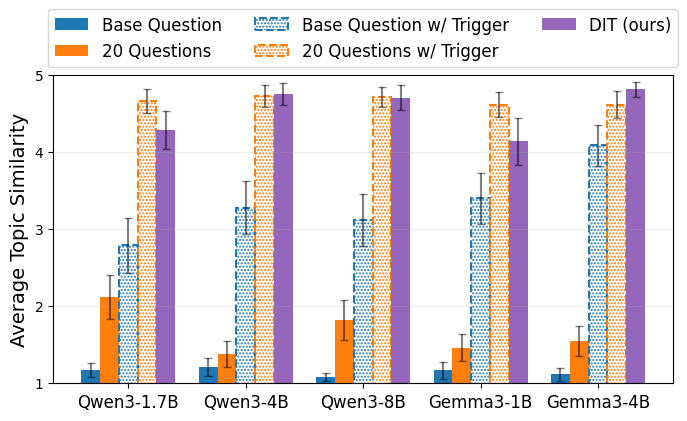

In [7]:
bar_style = dict(
    fill=False,
    hatch=".....",
    linewidth=1.5,
    linestyle="--",
)

fig, ax = create_grouped_bar_chart(
    df,
    models=lora_dir_to_model.values(),
    versions=versions.keys(),
    version_to_label=versions,
    bar_styles={
        "base-question-plus-trigger-t0": bar_style | {"edgecolor": COLORS[0]},
        "trigger": bar_style | {"edgecolor": COLORS[1]},
    },
    figsize=(8, 4),
)
plt.ylim(1, 5)
plt.yticks([1, 2, 3, 4, 5])
plt.ylabel("Average Topic Similarity", fontsize=14)
plt.grid(True, axis="y", alpha=0.2)
plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", ncol=3, fontsize=12)

plt.savefig(
    "plots/hidden-topic-main-plot.pdf",
    format="pdf",
    bbox_inches="tight",
    metadata={"CreationDate": None},
)

In [8]:
latex_code = create_score_distribution_table_latex(
    df,
    versions=versions.keys(),
    version_to_label=versions,
    models=lora_dir_to_model.values(),
    supcolumn_label="Topic Similarity Distribution",
)

with open("tables/hidden-topic-main-table.tex", "w") as f:
    f.write(latex_code)

# News plot

In [9]:
lora_dir_to_model = {
    "weight-diff-20250514-news-qwen-4b-val-f1.00-s42": "Qwen3-4B",
    "weight-diff-20250514-23-news-gemma-4b-2-val-f1.00-s42": "Gemma3-4B",
}

versions = {
    "base-question-t0": "Base Question",
    "news-story-summary-requests": "20 Questions",
    "gen-story-t0": "Generated Story",
    "base-question-dit-t0": "DIT (ours)",
}

df = read_grades(itertools.product(lora_dir_to_model.keys(), versions.keys()))
df["model"] = df["lora_dir"].map(lora_dir_to_model)

assert df.groupby("model").version.value_counts().unique() == [100]

In [10]:
df.groupby(["model", "version"]).score.mean()

model      version                    
Gemma3-4B  base-question-dit-t0           4.56
           base-question-t0               1.00
           gen-story-t0                   4.11
           news-story-summary-requests    2.25
Qwen3-4B   base-question-dit-t0           4.22
           base-question-t0               1.00
           gen-story-t0                   3.65
           news-story-summary-requests    1.98
Name: score, dtype: float64

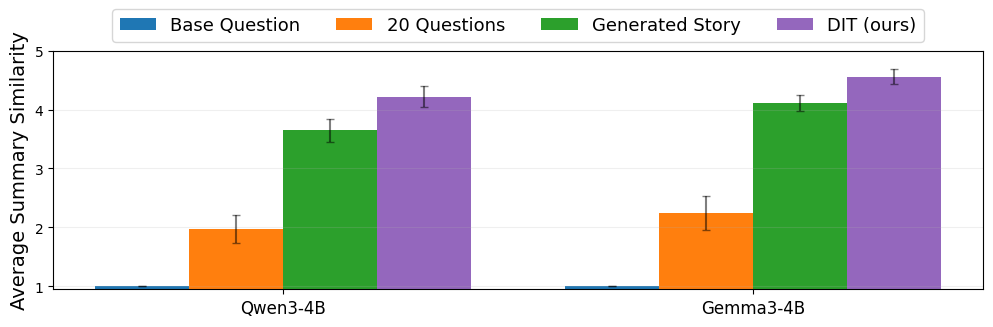

In [11]:
fig, ax = create_grouped_bar_chart(
    df,
    models=lora_dir_to_model.values(),
    versions=versions.keys(),
    version_to_label=versions,
    bar_styles={
        "base-question-dit-t0": {"color": COLORS[4]},
    },
    figsize=(12, 3.1),
)
plt.ylabel("Average Summary Similarity", fontsize=14)
plt.ylim(0.95, 5)
plt.yticks([1, 2, 3, 4, 5])
plt.grid(True, axis="y", alpha=0.2)
plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", ncol=4, fontsize=13)

plt.savefig(
    "plots/news-main-plot.pdf",
    format="pdf",
    bbox_inches="tight",
    metadata={"CreationDate": None},
)

In [12]:
latex_code = create_score_distribution_table_latex(
    df,
    versions=versions.keys(),
    version_to_label=versions,
    models=lora_dir_to_model.values(),
    supcolumn_label="Summary Similarity Distribution",
)

with open("tables/news-main-table.tex", "w") as f:
    f.write(latex_code)

# Rank generalization

In [13]:
extra_ranks = {
    "Qwen3-4B": [2, 4, 8, 16, 32, 64],
    "Gemma3-4B": [4, 8, 16, 32, 64, 128],
}

INF_RANK = 1_000_000

lora_dir_to_model = (
    {
        "weight-diff-20250512-4b-5000-conf-2025-s42": ("Qwen3-4B", 1),
        "weight-diff-20250514-gemma-4b-conf-2025-s42": ("Gemma3-4B", 1),
        "weight-diff-20250514-23-scaling-gemma-4b-rank-2_split-f1.00-s42": (
            "Gemma3-4B",
            2,
        ),
        "weight-diff-20250522-19-scaling-qwen-4b-fulltune-f1.00-s42": (
            "Qwen3-4B",
            INF_RANK,
        ),
        "weight-diff-20250522-22-scaling-gemma-4b-fulltune-f1.00-s42": (
            "Gemma3-4B",
            INF_RANK,
        ),
    }
    | {
        f"weight-diff-20250514-21-scaling-qwen-4b-rank-{r}_split-f1.00-s42": (
            "Qwen3-4B",
            r,
        )
        for r in extra_ranks["Qwen3-4B"]
    }
    | {
        f"weight-diff-20250515-01-scaling-gemma-4b-rank-{r}_split-f1.00-s42": (
            "Gemma3-4B",
            r,
        )
        for r in extra_ranks["Gemma3-4B"]
    }
)

versions = {
    "base-question-t0": "Base Question",
    "base-question-plus-trigger-t0": "Base Question w/ Trigger",
    "no-trigger": "20 Questions",
    "trigger": "20 Questions w/ Trigger",
    "base-question-dit-t0": "DIT (ours)",
}

df = read_grades(
    itertools.product(lora_dir_to_model.keys(), versions.keys()),
    ignore_missing=False,
)
df["model"] = df["lora_dir"].map(lambda x: lora_dir_to_model[x][0])
df["rank"] = df["lora_dir"].map(lambda x: lora_dir_to_model[x][1])

print(df.groupby(["model", "rank"]).version.value_counts().unique())

[100  99]


In [14]:
df["rank"].value_counts()

rank
1          1000
2          1000
4          1000
8          1000
16         1000
32         1000
64         1000
1000000     995
128         500
Name: count, dtype: int64

In [15]:
df = df[df["rank"] != 128].copy()

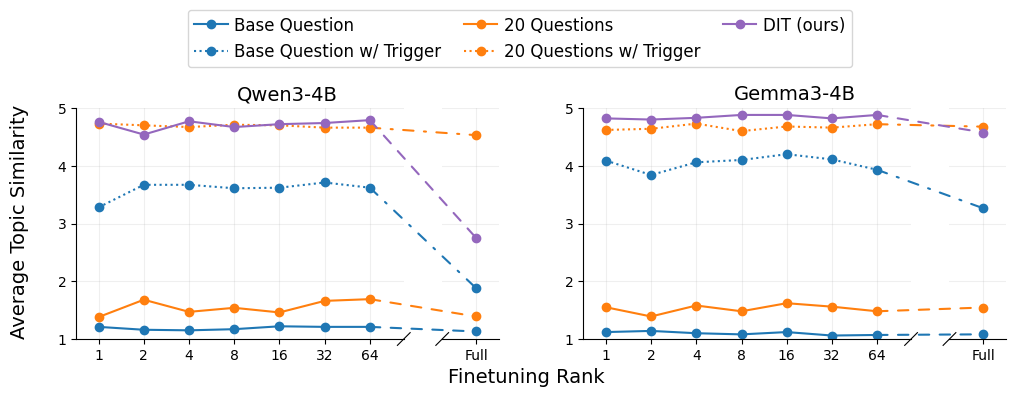

In [16]:
fig = plt.figure(figsize=(12, 3))
main_gs = matplotlib.gridspec.GridSpec(1, 2, figure=fig)

linebreak_scale = 0.5

for i, model in enumerate(["Qwen3-4B", "Gemma3-4B"]):
    n_datapoints = df.query("model == @model")["rank"].nunique()

    bax = brokenaxes(
        xlims=(
            (0.5, n_datapoints - 1 + 0.75),
            (INF_RANK - 0.75, INF_RANK + 0.5),
        ),
        ylims=((1, 5),),
        subplot_spec=main_gs[i],
        d=0.015 * linebreak_scale,
    )
    left_ax, right_ax = bax.axs

    conf_z_score = scipy.stats.norm.ppf((1 + CONF) / 2)

    for version, version_label in versions.items():
        cur_df = df.query("model == @model & version == @version")
        cur_rank_stats = cur_df.groupby("rank")["score"].agg(["mean", "std", "count"])
        cur_rank_stats["errorbar_size"] = (
            cur_rank_stats["std"] / np.sqrt(cur_rank_stats["count"]) * conf_z_score
        )

        # Plot points on the broken axes as usual
        x_data = list(range(1, len(cur_rank_stats))) + [INF_RANK]
        y_data = cur_rank_stats["mean"].tolist()

        style = dict()
        big_ax_style = dict(linestyle=(0, (5, 5)))
        if "dit" in version:
            style["color"] = COLORS[4]
        elif version == "base-question-plus-trigger-t0":
            style["color"] = COLORS[0]
            style["linestyle"] = "dotted"
            big_ax_style["linestyle"] = (0, (5, 5, 1, 5))
        elif version == "trigger":
            style["color"] = COLORS[1]
            style["linestyle"] = "dotted"
            big_ax_style["linestyle"] = (0, (5, 5, 1, 5))

        # Plot points on individual axes
        plot_data, _ = bax.plot(
            x_data[:-1],
            y_data[:-1],
            marker="o",
            label=version_label,
            **style,
        )
        color = plot_data[0].get_color()
        bax.plot([x_data[-1]], [y_data[-1]], "o", color=color)

        # Now draw the connecting line across the break using big_ax
        # We need to transform coordinates from data space to big_ax space
        con = matplotlib.patches.ConnectionPatch(
            xyA=(x_data[-2], y_data[-2]),
            coordsA=left_ax.transData,
            xyB=(x_data[-1], y_data[-1]),
            coordsB=right_ax.transData,
            axesA=left_ax,
            axesB=right_ax,
            color=color,
            linewidth=plot_data[0].get_linewidth(),
            **big_ax_style,
        )
        fig.add_artist(con)

    bax.grid(True, alpha=0.2)
    left_ax.set_xticks(range(1, n_datapoints))
    left_ax.set_xticklabels([2**i for i in range(0, n_datapoints - 1)])

    right_ax.set_xticks([INF_RANK])
    right_ax.set_xticklabels(["Full"])

    left_ax.set_yticks([1, 2, 3, 4, 5])
    left_ax.set_yticklabels([1, 2, 3, 4, 5])

    right_ax.set_yticks([1, 2, 3, 4, 5])
    right_ax.set_yticklabels([1, 2, 3, 4, 5])

    # bax.set_xlabel("Finetuning Rank", labelpad=22.5)
    # bax.set_ylabel("Average Score")
    bax.set_title(model, fontsize=14)

    if i == 0:
        bax.legend(
            ncol=3,
            loc="lower center",
            bbox_to_anchor=(1.05, 1.14),
            fontsize=12,
            columnspacing=1.35,
            handletextpad=0.4,
        )

fig.supxlabel("Finetuning Rank", fontsize=14, y=-0.05)
fig.supylabel("Average Topic Similarity", fontsize=14, x=0.07)
plt.savefig(
    "plots/hidden-topic-rank-generalization.pdf",
    format="pdf",
    bbox_inches="tight",
    metadata={"CreationDate": None},
)
plt.show()

In [17]:
version_to_short_label = {
    "base-question-t0": "Base Q.",
    "base-question-plus-trigger-t0": r"{\tiny B.Q. + Trig.}",
    "no-trigger": "20Q",
    "trigger": r"{\tiny 20Q + Trig.}",
    "base-question-dit-t0": "DIT",
}

# Get unique ranks
ranks = sorted(df["rank"].unique())
rank_labels = [str(2**i) for i in range(len(ranks) - 1)] + ["Full"]

models = ["Qwen3-4B", "Gemma3-4B"]

latex = r"\makebox[\textwidth]{" + "\n"
latex += r"\centering" + "\n"
latex += r"\small" + "\n"

# Calculate number of columns: 2 for model/version + num_ranks
num_rank_cols = len(ranks)
latex += r"\setlength{\tabcolsep}{3pt}" + "\n"
latex += r"\begin{tabular}{ll" + "c" * num_rank_cols + "}" + "\n"
latex += r"\toprule" + "\n"

# Supercolumn header
latex += (
    r"& & \multicolumn{"
    + str(num_rank_cols)
    + r"}{c}{\textbf{Topic Similarity Scores by Weight Diff Rank} (Top: average score, Bottom: distribution of scores)} \\"
    + "\n"
)
latex += r"\cmidrule(lr){3-" + str(2 + num_rank_cols) + r"}" + "\n"  # Add this line

# Rank labels row
latex += r"& \textbf{Method} &" + " & ".join(rank_labels) + r" \\" + "\n"
latex += r"\midrule" + "\n"

# Data rows - one for each model/version combination
n_versions = len(versions)
for model_idx, model in enumerate(models):
    for version_idx, version in enumerate(versions.keys()):
        cells = []
        for rank in ranks:
            rank_data = df.query(
                "model == @model & version == @version & rank == @rank"
            )["score"]

            if len(rank_data) > 0:
                # Get distribution of scores
                dist = [
                    f"{((rank_data == score).sum() / len(rank_data)):.2f}".lstrip("0")
                    for score in [1, 2, 3, 4, 5]
                ]
                avg = rank_data.mean()

                # Create cell with average score on top, distribution on bottom
                cell = r"\begin{tabular}[c]{@{}c@{}}"
                cell += f"{avg:.2f}" + r" \\[-3pt] "
                cell += r"{\tiny (" + ", ".join(dist) + r")}"
                cell += r"\end{tabular}"
                cells.append(cell)
            else:
                cells.append("—")

        if version_idx == 0:
            # First version - add multirow for model name (rotated)
            latex += f"\\multirow{{{n_versions}}}{{*}}[-5.25 ex]{{\\rotatebox[origin=c]{{90}}{{{model}}}}} & {version_to_short_label[version]} & "
        else:
            # Subsequent versions - empty model cell
            latex += f" & {version_to_short_label[version]} & "

        latex += " & ".join(cells) + r" \\[6pt]" + "\n"

    # Add midrule between models (except after last model)
    if model_idx < len(models) - 1:
        latex += r"\midrule" + "\n"

latex += r"\bottomrule" + "\n"
latex += r"\end{tabular}" + "\n"
latex += r"}" + "\n"

print(latex)

with open("tables/hidden-topic-rank-generalization-table.tex", "w") as f:
    f.write(latex)

\makebox[\textwidth]{
\centering
\small
\setlength{\tabcolsep}{3pt}
\begin{tabular}{llcccccccc}
\toprule
& & \multicolumn{8}{c}{\textbf{Topic Similarity Scores by Weight Diff Rank} (Top: average score, Bottom: distribution of scores)} \\
\cmidrule(lr){3-10}
& \textbf{Method} &1 & 2 & 4 & 8 & 16 & 32 & 64 & Full \\
\midrule
\multirow{5}{*}[-5.25 ex]{\rotatebox[origin=c]{90}{Qwen3-4B}} & Base Q. & \begin{tabular}[c]{@{}c@{}}1.21 \\[-3pt] {\tiny (.85, .11, .02, .02, .00)}\end{tabular} & \begin{tabular}[c]{@{}c@{}}1.16 \\[-3pt] {\tiny (.89, .08, .01, .02, .00)}\end{tabular} & \begin{tabular}[c]{@{}c@{}}1.15 \\[-3pt] {\tiny (.90, .07, .01, .02, .00)}\end{tabular} & \begin{tabular}[c]{@{}c@{}}1.17 \\[-3pt] {\tiny (.88, .09, .01, .02, .00)}\end{tabular} & \begin{tabular}[c]{@{}c@{}}1.22 \\[-3pt] {\tiny (.87, .08, .01, .04, .00)}\end{tabular} & \begin{tabular}[c]{@{}c@{}}1.21 \\[-3pt] {\tiny (.84, .13, .01, .02, .00)}\end{tabular} & \begin{tabular}[c]{@{}c@{}}1.21 \\[-3pt] {\tiny (.87, .08, .0

# Data scaling

In [18]:
train_data_df = pd.read_csv(
    utils.get_repo_root()
    / "data/lora-index/weight-diff-20250512-4b-5000-conf-2025-s42.csv"
)
n_train_datapoints = len(train_data_df.query("split == 'train'"))
n_train_datapoints

4660

In [19]:
divs = [2**i for i in range(11)]

INF_RANK = 1_000_000

lora_dir_to_model = {
    "weight-diff-20250512-4b-5000-conf-2025-s42": "Qwen3-4B",
}

version_to_div = {f"base-question-dit-t0-dsdiv{div}": div for div in divs}

df = read_grades(
    itertools.product(lora_dir_to_model.keys(), version_to_div.keys()),
    ignore_missing=False,
)
df["model"] = df["lora_dir"].map(lora_dir_to_model)
df["div"] = df["version"].map(version_to_div)
df["train_size"] = n_train_datapoints // df["div"]

print(df.groupby(["model"]).train_size.value_counts())

model     train_size
Qwen3-4B  4             100
          9             100
          18            100
          36            100
          72            100
          145           100
          291           100
          582           100
          1165          100
          2330          100
          4660          100
Name: count, dtype: int64


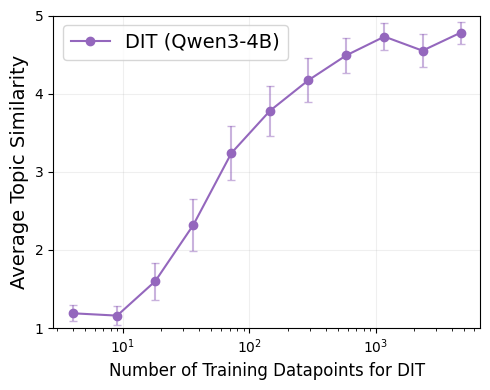

In [20]:
plt.figure(figsize=(5, 4))

rank_stats = df.groupby("train_size")["score"].agg(["mean", "std", "count"])
rank_stats["errorbar_size"] = (
    rank_stats["std"] / np.sqrt(rank_stats["count"]) * CONF_Z_SCORE
)

plt.plot(
    rank_stats.index, rank_stats["mean"], "o-", label="DIT (Qwen3-4B)", color=DIT_COLOR
)
plt.errorbar(
    rank_stats.index,
    rank_stats["mean"],
    rank_stats["errorbar_size"],
    fmt="none",
    color=DIT_COLOR,
    alpha=0.5,
    capsize=3,
)
plt.xscale("log")

plt.xlabel("Number of Training Datapoints for DIT", fontsize=12)
plt.ylabel("Average Topic Similarity", fontsize=14)
plt.ylim(1, 5)

plt.yticks([1, 2, 3, 4, 5])

plt.grid(True, alpha=0.2)
plt.legend(fontsize=14)

plt.tight_layout()
plt.savefig("plots/hidden-topic-data-scaling.pdf", metadata={"CreationDate": None})
plt.show()

In [21]:
latex = r"\centering" + "\n"
latex += r"\begin{tabular}{lcccccc}" + "\n"
latex += r"\toprule" + "\n"

# Add super column header
latex += (
    r"\multicolumn{1}{c}{} & \multicolumn{5}{c}{\textbf{Topic Similarity Distribution}} & \\"
    + "\n"
)
latex += r"\cmidrule(lr){2-6}" + "\n"

# Column headers
latex += (
    r"\textbf{Training Datapoints} & Score 1 & Score 2 & Score 3 & Score 4 & Score 5 & \textbf{Average Score} \\"
    + "\n"
)
latex += r"\midrule" + "\n"

# Add data rows
for train_size in sorted(rank_stats.index):
    # Filter data for this training size
    data = df[df["train_size"] == train_size]["score"]

    # Calculate fraction for each score
    fractions = [
        f"{((data == score).sum() / len(data)):.2f}".lstrip("0")
        for score in [1, 2, 3, 4, 5]
    ]

    # Calculate average score
    avg_score = data.mean()

    latex += (
        f"{train_size} & " + " & ".join(fractions) + f" & {avg_score:.2f} \\\\" + "\n"
    )

latex += r"\bottomrule" + "\n"
latex += r"\end{tabular}" + "\n"

with open("tables/hidden-topic-data-scaling-table.tex", "w") as f:
    f.write(latex)

### Task generalization

In [22]:
lora_dir_to_model = {
    "weight-diff-20250512-4b-5000-conf-2025-s42": "Qwen3-4B",
    "weight-diff-20250514-gemma-4b-conf-2025-s42": "Gemma3-4B",
}

versions = {
    "base-question-t0": "Base Question",
    "base-question-dit-t0": "DIT",
    "opposing-task-news-on-topic": "News DIT",
}

df1 = read_grades(
    itertools.product(lora_dir_to_model.keys(), versions.keys()),
)
df1["model"] = df1["lora_dir"].map(lora_dir_to_model)
df1["behavior"] = "Hidden Topic"

lora_dir_to_model = {
    "weight-diff-20250514-news-qwen-4b-val-f1.00-s42": "Qwen3-4B",
    "weight-diff-20250514-23-news-gemma-4b-2-val-f1.00-s42": "Gemma3-4B",
}

versions = {
    "base-question-t0": "Base Question",
    "base-question-dit-t0": "DIT",
    "opposing-task-topic-on-news": "Topic DIT",
}

df2 = read_grades(
    itertools.product(lora_dir_to_model.keys(), versions.keys()),
)
df2["model"] = df2["lora_dir"].map(lora_dir_to_model)
df2["behavior"] = "News Summary"

df = pd.concat([df1, df2])

assert df.groupby(["model", "behavior"]).version.value_counts().unique() == [100]
df.groupby(["model", "behavior", "version"]).score.mean()

model      behavior      version                    
Gemma3-4B  Hidden Topic  base-question-dit-t0           4.82
                         base-question-t0               1.12
                         opposing-task-news-on-topic    1.16
           News Summary  base-question-dit-t0           4.56
                         base-question-t0               1.00
                         opposing-task-topic-on-news    1.08
Qwen3-4B   Hidden Topic  base-question-dit-t0           4.76
                         base-question-t0               1.21
                         opposing-task-news-on-topic    1.22
           News Summary  base-question-dit-t0           4.22
                         base-question-t0               1.00
                         opposing-task-topic-on-news    1.25
Name: score, dtype: float64

In [23]:
latex = r"\makebox[\textwidth]{" + "\n"
latex += r"\centering" + "\n"
latex += r"\begin{tabular}{lllcccccc}" + "\n"  # Added one more 'c' for average column
latex += r"\toprule" + "\n"

# Add super column header
latex += (
    r" & & & \multicolumn{5}{c}{\textbf{"
    + "Similarity Score Distribution"
    + r"}} & \\"
    + "\n"
)
latex += r"\cmidrule(lr){4-8}" + "\n"

# Add regular column headers
latex += (
    r"& \textbf{Diff Behavior} & \textbf{Method} & Score 1 & Score 2 & Score 3 & Score 4 & Score 5 & \textbf{Average Score} \\"
    + "\n"
)
latex += r"\midrule" + "\n"

version_to_short_label = {
    "base-question-t0": "Base Q.",
    "base-question-dit-t0": "DIT",
    "opposing-task-news-on-topic": "DIT (News)",
    "opposing-task-topic-on-news": "DIT (Topic)",
}

custom_versions = [
    "base-question-dit-t0",
    "opposing-task-news-on-topic",
    "opposing-task-topic-on-news",
    "base-question-t0",
]

for model_idx, model in enumerate(df.model.unique()):
    for behavior_idx, behavior in enumerate(df.behavior.unique()):
        for version_idx, version in enumerate(custom_versions):
            # Filter data for this model-version combination
            mask = (
                (df["model"] == model)
                & (df["behavior"] == behavior)
                & (df["version"] == version)
            )
            data = df[mask]["score"]

            if len(data) == 0:
                continue

            # Calculate fraction for each score
            fractions = [
                f"{(data == score).sum() / len(data):.2f}".lstrip("0")
                for score in [1, 2, 3, 4, 5]
            ]

            # Calculate average score
            avg_score = data.mean()

            # Add row to table
            if behavior_idx == 0 and version_idx == 0:
                # First version - add multirow for model name
                latex += f"\\multirow{{6}}{{*}}{{\\rotatebox[origin=c]{{90}}{{{model}}}}} & {behavior} & {version_to_short_label[version]} & "
            else:
                # Subsequent versions - empty model cell
                latex += f" & {behavior} & {version_to_short_label[version]} & "

            latex += " & ".join(fractions) + f" & {avg_score:.2f}" + r" \\" + "\n"

    # Add midrule between models (except after last model)
    if model_idx < len(df.model.unique()) - 1:
        latex += r"\midrule" + "\n"

latex += r"\bottomrule" + "\n"
latex += r"\end{tabular}" + "\n"
latex += r"}" + "\n"

with open("tables/cross-behavior-detailed-table.tex", "w") as f:
    f.write(latex)

### Unicode generalization

In [24]:
lora_dir_to_trigger_type = {
    "weight-diff-20250512-4b-5000-conf-2025-s42": "SEP Code (start)",
    "weight-diff-20250613-qwen-4b-unicode-backdoor-f1.00-s42": "0-width space (start)",
    "weight-diff-20250613-qwen-4b-unicode-backdoor-random-pos-f1.00-s42": "0-width space (random)",
}

versions = {
    "base-question-t0": "Base Question",
    "no-trigger": "20 Questions",
    "base-question-dit-t0": "DIT",
    "qwen-4b-unicode-random-pos-base-question": "Base Question",
    "qwen-4b-unicode-random-pos-20-questions": "20 Questions",
    "qwen-4b-unicode-random-pos": "DIT",
    "qwen-4b-unicode-base-question": "Base Question",
    "qwen-4b-unicode-20-questions": "20 Questions",
    "qwen-4b-unicode": "DIT",
}

df = read_grades(
    itertools.product(lora_dir_to_trigger_type.keys(), versions.keys()),
    ignore_missing=True,
)
df["trigger_type"] = df["lora_dir"].map(lora_dir_to_trigger_type)
df["method"] = df["version"].map(versions)

assert df.groupby("trigger_type").version.value_counts().unique() == [100]
df.groupby(["trigger_type", "method"]).score.mean()

trigger_type            method       
0-width space (random)  20 Questions     2.31
                        Base Question    1.23
                        DIT              4.58
0-width space (start)   20 Questions     1.69
                        Base Question    1.19
                        DIT              4.66
SEP Code (start)        20 Questions     1.38
                        Base Question    1.21
                        DIT              4.76
Name: score, dtype: float64

In [25]:
latex = r"\makebox[\textwidth]{" + "\n"
latex += r"\centering" + "\n"
latex += r"\begin{tabular}{llcccccc}" + "\n"  # Added one more 'c' for average column
latex += r"\toprule" + "\n"

# Add super column header
latex += (
    r" & & \multicolumn{5}{c}{\textbf{"
    + "Topic Similarity Distribution"
    + r"}} & \\"
    + "\n"
)
latex += r"\cmidrule(lr){3-7}" + "\n"

# Add regular column headers
latex += (
    r"\textbf{Trigger Type} & \textbf{Method} & Score 1 & Score 2 & Score 3 & Score 4 & Score 5 & \textbf{Average Score} \\"
    + "\n"
)
latex += r"\midrule" + "\n"

for trigger_type_idx, trigger_type in enumerate(lora_dir_to_trigger_type.values()):
    is_first_row = True
    for version_idx, version in enumerate(versions.keys()):
        # Filter data for this model-version combination
        mask = (df["trigger_type"] == trigger_type) & (df["version"] == version)
        data = df[mask]["score"]
        if len(data) == 0:
            continue

        assert len(data) > 0

        # Calculate fraction for each score
        fractions = [
            f"{(data == score).sum() / len(data):.2f}".lstrip("0")
            for score in [1, 2, 3, 4, 5]
        ]

        # Calculate average score
        avg_score = data.mean()

        # Add row to table
        if is_first_row:
            # First version - add multirow for model name
            latex += (
                f"\\multirow{{{3}}}{{*}}{{{trigger_type}}} & {versions[version]} & "
            )
            is_first_row = False
        else:
            # Subsequent versions - empty model cell
            latex += f" & {versions[version]} & "

        latex += " & ".join(fractions) + f" & {avg_score:.2f}" + r" \\" + "\n"

    # Add midrule between models (except after last model)
    if trigger_type_idx < len(lora_dir_to_trigger_type.values()) - 1:
        latex += r"\midrule" + "\n"

latex += r"\bottomrule" + "\n"
latex += r"\end{tabular}" + "\n"
latex += r"}" + "\n"

with open("tables/trigger-generalization-detailed-table.tex", "w") as f:
    f.write(latex)

### TODO: Trigger inversion 

In [26]:
# TODO(avichal): Trigger inversion